In [2]:
# Imports
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy import signal
from scipy.fft import fftshift
from mpl_toolkits import mplot3d
import os

In [3]:
# Creating base data
# used to see the wav files and the emotion it's associated with. Don't modify this dataframe. 
# It'll be used to make the main dataframe
mdf = pd.DataFrame(columns=["emotion", "wav"])
crema = "./Crema/"

sad=[]
angry=[]
disgust=[]
fear=[]
happy=[]
neutral=[]

for wav in os.listdir(crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        mdf.loc[len(mdf.index)] = ['sad', wavfile.read(crema + wav)[1]]
    elif info[2] == 'ANG':
        mdf.loc[len(mdf.index)] = ['angry', wavfile.read(crema + wav)[1]]
    elif info[2] == 'DIS':
        mdf.loc[len(mdf.index)] = ['disgust', wavfile.read(crema + wav)[1]]
    elif info[2] == 'FEA':
        mdf.loc[len(mdf.index)] = ['fear', wavfile.read(crema + wav)[1]]
    elif info[2] == 'HAP':
        mdf.loc[len(mdf.index)] = ['happy', wavfile.read(crema + wav)[1]]
    elif info[2] == 'NEU':
        mdf.loc[len(mdf.index)] = ['neutral', wavfile.read(crema + wav)[1]]

In [4]:
# make all audio files the same length
max1=0
min1=500000

# longest and shortest wav files
for i in range(0,len(mdf["wav"])):
    if len(mdf["wav"].loc[i]) > max1:
        max1 = len(mdf["wav"].loc[i])
    if len(mdf["wav"].loc[i]) < min1:
        min1 = len(mdf["wav"].loc[i])
print(max1)
print(min1)

# longest wav file is ~80000, shortest is ~20000
# using the middle 10000 samples of every file.
samples=10000

for i in range(0,len(mdf["wav"])):
    half_len = int(len(mdf["wav"].loc[i])/2)
    mdf["wav"].loc[i] = mdf["wav"].loc[i][half_len-5000:half_len+5000]

80080
20287


In [5]:
print(mdf.head())

   emotion                                                wav
0    angry  [-488, -460, -380, -1039, -1339, -1625, -1420,...
1  disgust  [-783, -832, -907, -971, -1116, -1309, -1455, ...
2     fear  [-3545, -4374, -5472, -5404, -4558, -4247, -41...
3    happy  [-371, -1022, -949, -981, -357, -608, -981, -8...
4  neutral  [536, 464, 280, 148, 58, 32, 113, 244, 382, 42...


In [6]:
# Create dataframe used for manipulation
df = mdf.copy()
df = df.drop(columns=["wav"])
df["mean"]=0
df["rmse"]=0

# calc rmse
def rmse(sig):
    total=0
    for i in range(0,samples):
        total += sig[i]**2
    rms = np.sqrt(abs(total/samples))
    return rms

# Add more features here based off the wave itself

for i in range(0, len(df)):
    # save the mean. Probably wont really use.
    df["mean"].loc[i] = abs(mdf["wav"].loc[i].mean())
    # save rms of the energy of the signal
    df["rmse"].loc[i] = rmse(mdf["wav"].loc[i])
    

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\devli\AppData\Local\Temp/ipykernel_13528/3737530147.py:11: RuntimeWarning: overflow encountered in int_scalars
  total += sig[i]**2


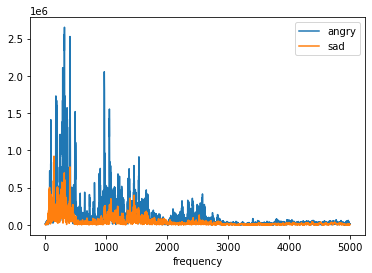

In [7]:
# visualize fft
# rate1, sig1 = wavfile.read(crema + "1001_DFA_ANG_XX.wav")
# rate2, sig2 = wavfile.read(crema + "1001_DFA_SAD_XX.wav")
sig1 = mdf["wav"].loc[0]
sig2 = mdf["wav"].loc[5]
sig_f1 = abs(np.fft.fft(sig1))
sig_f2 = abs(np.fft.fft(sig2))
len_f1 = len(sig_f1)
len_f2 = len(sig_f2)
half_len_f1 = int(np.ceil((len_f1 + 1) / 2))
half_len_f2 = int(np.ceil((len_f2 + 1) / 2))
sig_f1 = sig_f1[:half_len_f1]
sig_f2 = sig_f2[:half_len_f2]

plt.plot(sig_f1)
plt.plot(sig_f2)
plt.xlabel("frequency")
plt.legend(["angry", "sad"])

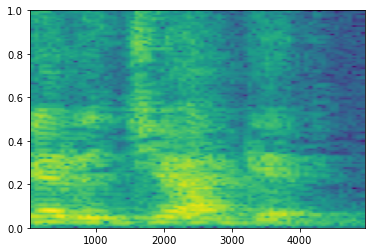

TypeError: Dimensions of C (129, 44) are incompatible with X (129) and/or Y (44); see help(pcolormesh)

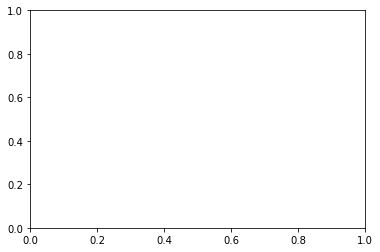

In [54]:
# frequency domain data

df["average frequency"]=0
df["highest peak over 800Hz"]=0

sample_rate = 10000

# for i in range(0, len(df)):
#     # temp_fft = abs(np.fft.rfft(mdf["wav"].loc[i]))
#     temp_f, temp_t, s = signal.spectrogram(mdf["wav"].loc[i], sample_rate)
#     df["average frequency"].loc[i] = temp_f
    # print(temp_f)
#     print(df["average frequency"].loc[i])
#     m = max(temp_fft)
#     df["highest peak over 800Hz"].loc[i] = np.where(t==k)
#     print(np.where(t==m))

a, b, c, d = plt.specgram(mdf["wav"].loc[3])
plt.show()

temp_f2, temp_t2, s2 = signal.spectrogram(mdf["wav"].loc[3], sample_rate)
plt.pcolormesh(temp_t2, temp_f2, 10*np.log10(s2), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
print(s2.flatten().mean())
# print(len(temp_t))
# print(temp_f1)
# plt.specgram(s)

In [9]:
print(df)

      emotion    mean        rmse  average frequency  highest peak over 800Hz
0       angry  1.7453  127.350955                  0                        0
1     disgust  3.3016  161.223955                  0                        0
2        fear  1.5374   53.893450                  0                        0
3       happy  0.4316   63.253941                  0                        0
4     neutral  0.8085  332.760436                  0                        0
...       ...     ...         ...                ...                      ...
7437  disgust  1.1738  382.380176                  0                        0
7438     fear  2.5016  332.629848                  0                        0
7439    happy  1.1280  293.561066                  0                        0
7440  neutral  1.8103  358.981813                  0                        0
7441      sad  1.0034  300.983002                  0                        0

[7442 rows x 5 columns]


   emotion    mean        rmse  average frequency  highest peak over 800Hz
0    angry  1.7453  127.350955                  0                        0
1  disgust  3.3016  161.223955                  0                        0
2     fear  1.5374   53.893450                  0                        0
3    happy  0.4316   63.253941                  0                        0
4  neutral  0.8085  332.760436                  0                        0
                             mean      rmse  average frequency  \
mean                     1.000000 -0.011466                NaN   
rmse                    -0.011466  1.000000                NaN   
average frequency             NaN       NaN                NaN   
highest peak over 800Hz       NaN       NaN                NaN   

                         highest peak over 800Hz  
mean                                         NaN  
rmse                                         NaN  
average frequency                            NaN  
highest peak ov

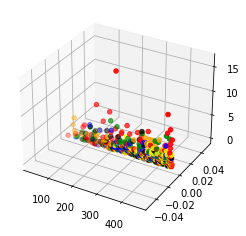

In [10]:
print(df.head())
print(df.corr())
colors = {"sad":"blue", "angry":"red", "disgust":"yellow", "fear":"orange", "happy":"green", "neutral":"black"}
# plt.scatter(np.abs(df["rmse"]), df["average frequency"], c=df["emotion"].map(colors))
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(np.abs(df["rmse"][:500]), df["average frequency"][:500], df["mean"][:500], c=df["emotion"][:500].map(colors))

In [11]:
# goal and features
goal = df["emotion"]
features = df[["rmse", "average frequency"]]

# split data
X_train, X_test, Y_train, Y_test = train_test_split(features, goal)

# use decision tree
model=tree.DecisionTreeClassifier(max_depth=5)

# train the model
model.fit(X_train,Y_train)

# training and testing accuracy
dtree_pred_train = model.predict(X_train)
dtree_pred_test = model.predict(X_test) 
print("Train Accuracy: ", accuracy_score(Y_train, dtree_pred_train))
print("Test Accuracy: ", accuracy_score(Y_test, dtree_pred_test))

# keras simplest
# pytorch
# tensor flow
# specified NN for time series

Train Accuracy:  0.20408528937466403
Test Accuracy:  0.18430951101558302
